這邊利用課本中的範例4.2來說明策略迭代的過程，程式碼主要參考的是[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter04/car_rental.py)，再加上自己理解的註解。

Example 4.2: Jack’s Car Rental
範例說的是，jack管理一家有兩個地點的汽車租賃公司，每天都會有人來租車。只要有車可以出租，每租一台出去就得到10元，沒車就沒搞頭。還車後的第二天，那台還回來的車就可以拿來出租。為了兩邊都有車可以用，jack會利用晚上來移動車子，每次的移動都需要2元的成本。我們假設每一個地點需求的汽車與歸還的汽車為Possion random variables([卜瓦松](https://zh.wikipedia.org/wiki/%E5%8D%9C%E7%93%A6%E6%9D%BE%E5%88%86%E5%B8%83)隨機變數)，意思就是數量$n$的機率為$\dfrac{\lambda^n}{n!}e^{-\lambda}$，其中$\lambda$是期望的數值。假設，兩地的出租需求$\lambda$是3跟4，然後歸還的是3與2。為了稍微簡化問題，我們再假設，每個地點最多就是20台車，多的就退回總公司，因此這個問題就是最多20台，然後一個晚上最多能移動的就是5台車。我們設置discount rate $\gamma = 0.9$，然後把這個問題弄成continuing finite MDP，time steps就是天(days)，state就是一天結束的時候每個地方擁有的汽車數量，然後actions就是晚上兩地移動的汽車的數量。Figure 4.2說明著從沒有移動任何車子的policy開始的policy iteration所找出的一系列的策略。


![](https://i.imgur.com/d3KXJEf.png)
Figure 4.2：Jack汽車出租問題利用策略迭代找出來的一系列的策略與最終的state-value function。前五張圖說明的是，每天結束時，每一個地點的汽車數量從一個點被移到另一個點(負值就代表從sencond location移往first location，反之，正就是從first location移到second location)。每個後續的策略(successive policy)都是從前一個策略(previous policy)嚴格改進(strict improvement)而來的，然後最後一個是optimal。

載入需求套件

`poisson`是關於[卜瓦松分布(Poisson distribution](https://zh.wikipedia.org/wiki/%E5%8D%9C%E7%93%A6%E6%9D%BE%E5%88%86%E5%B8%83)的function

更多關於Poisson distribution可以參考翁秉仁老師的[Poisson 分配、指數分配與排隊理論](http://episte.math.ntu.edu.tw/applications/ap_poisson/index.html)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson

%matplotlib inline 

下面定義環境中需要的參數

In [5]:
# 每一個地點能夠放的最大汽車數，超過的就假裝"送回總公司"
MAX_CARS = 20

In [6]:
# 每個晚上能夠移動的最大汽車數
MAX_MOVE_OF_CARS = 5

In [7]:
# 甲地的出租需求數
RENTAL_REQUEST_FIRST_LOC = 3

In [8]:
# 乙地的出租需求數
RENTAL_REQUEST_SECOND_LOC = 4

In [9]:
# 甲地的歸還汽車數
RETURNS_FIRST_LOC = 3

In [10]:
# 乙地的歸還汽車數
RETURNS_SECOND_LOC = 2

In [11]:
# discount rate
DISCOUNT = 0.9

In [12]:
# 出租一台車可以賺多少
RENTAL_CREDIT = 10

In [13]:
# 兩地之間移動汽車的成本
MOVE_CAR_COST = 2

所有可能的action，這個案例中我們的action就是要移動幾台的車子，來幾台還是去幾台

In [16]:
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
actions

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

[scipy_poisson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html)：
* 第一個參數放的是一段時間內會發生的次數
* 第二個參數放的是一段時間內平均發生的次數，也就是$\lambda$，在這個範例中就是3、4跟3、2

這邊設置一個參數，最多就是計算10台的車輛，超過了，得到的機率值似乎會被截斷為0，因此作者只計算0~10

In [45]:
POISSON_UPPER_BOUND = 11

In [41]:
# 用一個dict來記錄poisson distribution

poisson_cache = dict()

def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

In [42]:
for i in range(21):
    for j in [2,3,4]:
        poisson_probability(i, j)

下面計算expected return

大致流程
* (1)初始化returns，
* (2)計算移動車子的成本，這是由action決定，
* (3)計算兩地還車後的車輛數，
* (4)迴圈計算所有可能的租車排列組合，
    * (4-1)計算機率，兩地的租車是iid，因此相乘，
    * (4-2)確認出租車輛數，因為庫存(3)可能比(4)的租車數來的少，取小，
    * (4-3)計算reward，
    * (4-4)計算出租後的車輛數，
    * (4-5)計算returns，假設固定還車數，將剩餘車數(4-4)加上還車輛就是next state，以此計算returns

In [44]:
def expected_return(state, action, state_value, constant_returned_cars):
    """
    state: list，[甲地的車子數, 乙地的車子數]
    action: 甲地搬車到乙地就正值，乙地搬車到甲地就負值
    state_value: matrix，記錄state value
    constant_returned_cars: 如果設置為true，那每天歸還的汽車數就會是固定的，
                            而不是經由poisson distribution計算而來，
                            這可以降低計算時間
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # 初始化return
    returns = 0.0

    # 計算移動車子的成本
    # 範例設置是2元，action有正有負，記得取abs
    returns -= MOVE_CAR_COST * abs(action)

    # 利用state、action計算移動之後兩地的汽車數
    # 要注意的是，取min是因為範例有提過，一個地方能放的車最多就是20輛，超過的就"自動送回總公司"
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # 下面做出所有可能的出租需求的排列組合
    # 因為當車輛超過10台，也就是pmf(11, 3)所得到的機率變的超級小，因此作者就沒有列入計算
    # 最多會出租POISSON_UPPER_BOUND，但這個過程包含0、1、2、3、...、POISSON_UPPER_BOUND
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # 甲地、乙地兩地的出租機率是iid，因此相乘            
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            # 兩地的車輛數賦值
            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # 這邊要確認的是，你的租車需求必定小於等於你現有車輛數，所以取小
            # 我們也會用這個實際出租車輛數來計算所得
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # 計算兩地車輛出租之後的所得
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            # 計算兩地車輛出租之後剩餘車輛
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc
    
            # 判斷參數設置是否設置每日歸還數固定
            if constant_returned_cars:
                # 如果歸還數固定，那每日兩地就是3、2
                returned_cars_first_loc = RETURNS_FIRST_LOC # 3
                returned_cars_second_loc = RETURNS_SECOND_LOC # 2
                # 計算歸還之後車輛數，一樣的，最多最多就只能放20輛車
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                # 計算return，這一次的reward，加上next state的value
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                # 如果歸還數沒有固定，那就繼續迴圈把所有可能的還車數都計一次                
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        # 因為不固定，所以需要再考慮poisson probability
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        # 計算剩餘車輛數，這也是next state
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        # 跟固定歸還數的最大差異在於多考慮了還車的poisson probability
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

接著我們要來定義一個執行的函數。下面會說明幾個過程中會用到的函數

`axes.flatten`，將定義的subplot做平展，有沒有做對操作索引會有差異

`np.flipud`，[官方文件](https://numpy.org/doc/1.14/reference/generated/numpy.flipud.html)，將matrix、vector做翻轉

In [56]:
A = np.diag([1.0, 2, 3])
A

array([[1., 0., 0.],
       [0., 2., 0.],
       [0., 0., 3.]])

In [57]:
np.flipud(A)

array([[0., 0., 3.],
       [0., 2., 0.],
       [1., 0., 0.]])

下面這邊算是主要執行的部份，這分成兩塊，一個是policy evaluation，一個是policy improvement：
* policy evaluation: 利用bellman optimal equation，用$s_t$再加上$s_{t+1}$去更新計算value function，收斂至閥值之後停止
* policy improvement: 預設的policy都是0，我們會用policy evaluation得到的新的value function來對每個action來計算它的return，然後取最大的那一個來做為在該state下的action，因為我們的policy就是greedy

接下來判斷是否穩定，如果沒有穩定就再執行下一次迭代

In [74]:
def figure_4_2(constant_returned_cars=True):
    # 以我們的範例來看，就是設置兩個21x21的matrix
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=np.int)
    # 記錄迭代次數，也許我們會想知道收斂的進度
    iterations = 0
    # 設置figure、axes
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    # 透過flatten，就是把上面設置的2x3個sub fig平展，操作上的索引跟沒有設置flatten是不一樣的
    axes = axes.flatten()
    while True:
        # 設置圖表 
        fig = sns.heatmap(np.flipud(policy), cmap='YlGnBu', ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30 )
        fig.set_title(f'policy {iterations}', fontsize=30)
        # policy evaluation
        while True:            
            # 跟範例4.1一樣，我們先copy一個做舊值的記錄，
            old_values = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                                                    # state, action, state_value, constant_returned_cars
                    new_stata_value = expected_return([i, j], policy[i, j], value, constant_returned_cars=True)
                    # in-place更新目前state的value
                    value[i, j] = new_stata_value
            # 計算最大變化        
            max_value_change = abs(old_values - value).max()    
            print(f'max_value_change: {max_value_change}')
            # 判斷變化是否小於閥值，若是那就停止policy evaluation
            if max_value_change < 1e-4:
                print('stop policy evaluation.')
                break
        
        # policy improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                # 兩地之間車輛的搬運是從-5~+5
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-np.inf)
                    
                new_action = actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print(f'policy stable: {policy_stable}')

        if policy_stable:
            fig = sns.heatmap(np.flipud(value), cmap='YlGnBu', ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break
            
        iterations += 1
    plt.savefig('./figure_4_2.png')
    plt.show()
    plt.close()     

max_value_change: 196.62783361783852
max_value_change: 134.98823859766583
max_value_change: 91.41415360228919
max_value_change: 67.17097732555729
max_value_change: 51.29055484635097
max_value_change: 38.49091000659837
max_value_change: 29.406139835126424
max_value_change: 25.7210573245398
max_value_change: 22.381602293031023
max_value_change: 19.40385808254939
max_value_change: 16.77577350573091
max_value_change: 14.47251552455765
max_value_change: 12.464101852186843
max_value_change: 10.719367983418692
max_value_change: 9.20806226246873
max_value_change: 7.9019189666795455
max_value_change: 6.775146571130392
max_value_change: 5.8045764710083745
max_value_change: 4.969618520007145
max_value_change: 4.252112693842776
max_value_change: 3.6361309524054946
max_value_change: 3.107761240497666
max_value_change: 2.654891834022692
max_value_change: 2.26700589940549
max_value_change: 1.9349911763441128
max_value_change: 1.650966802154585
max_value_change: 1.4081276418079938
max_value_change: 1.

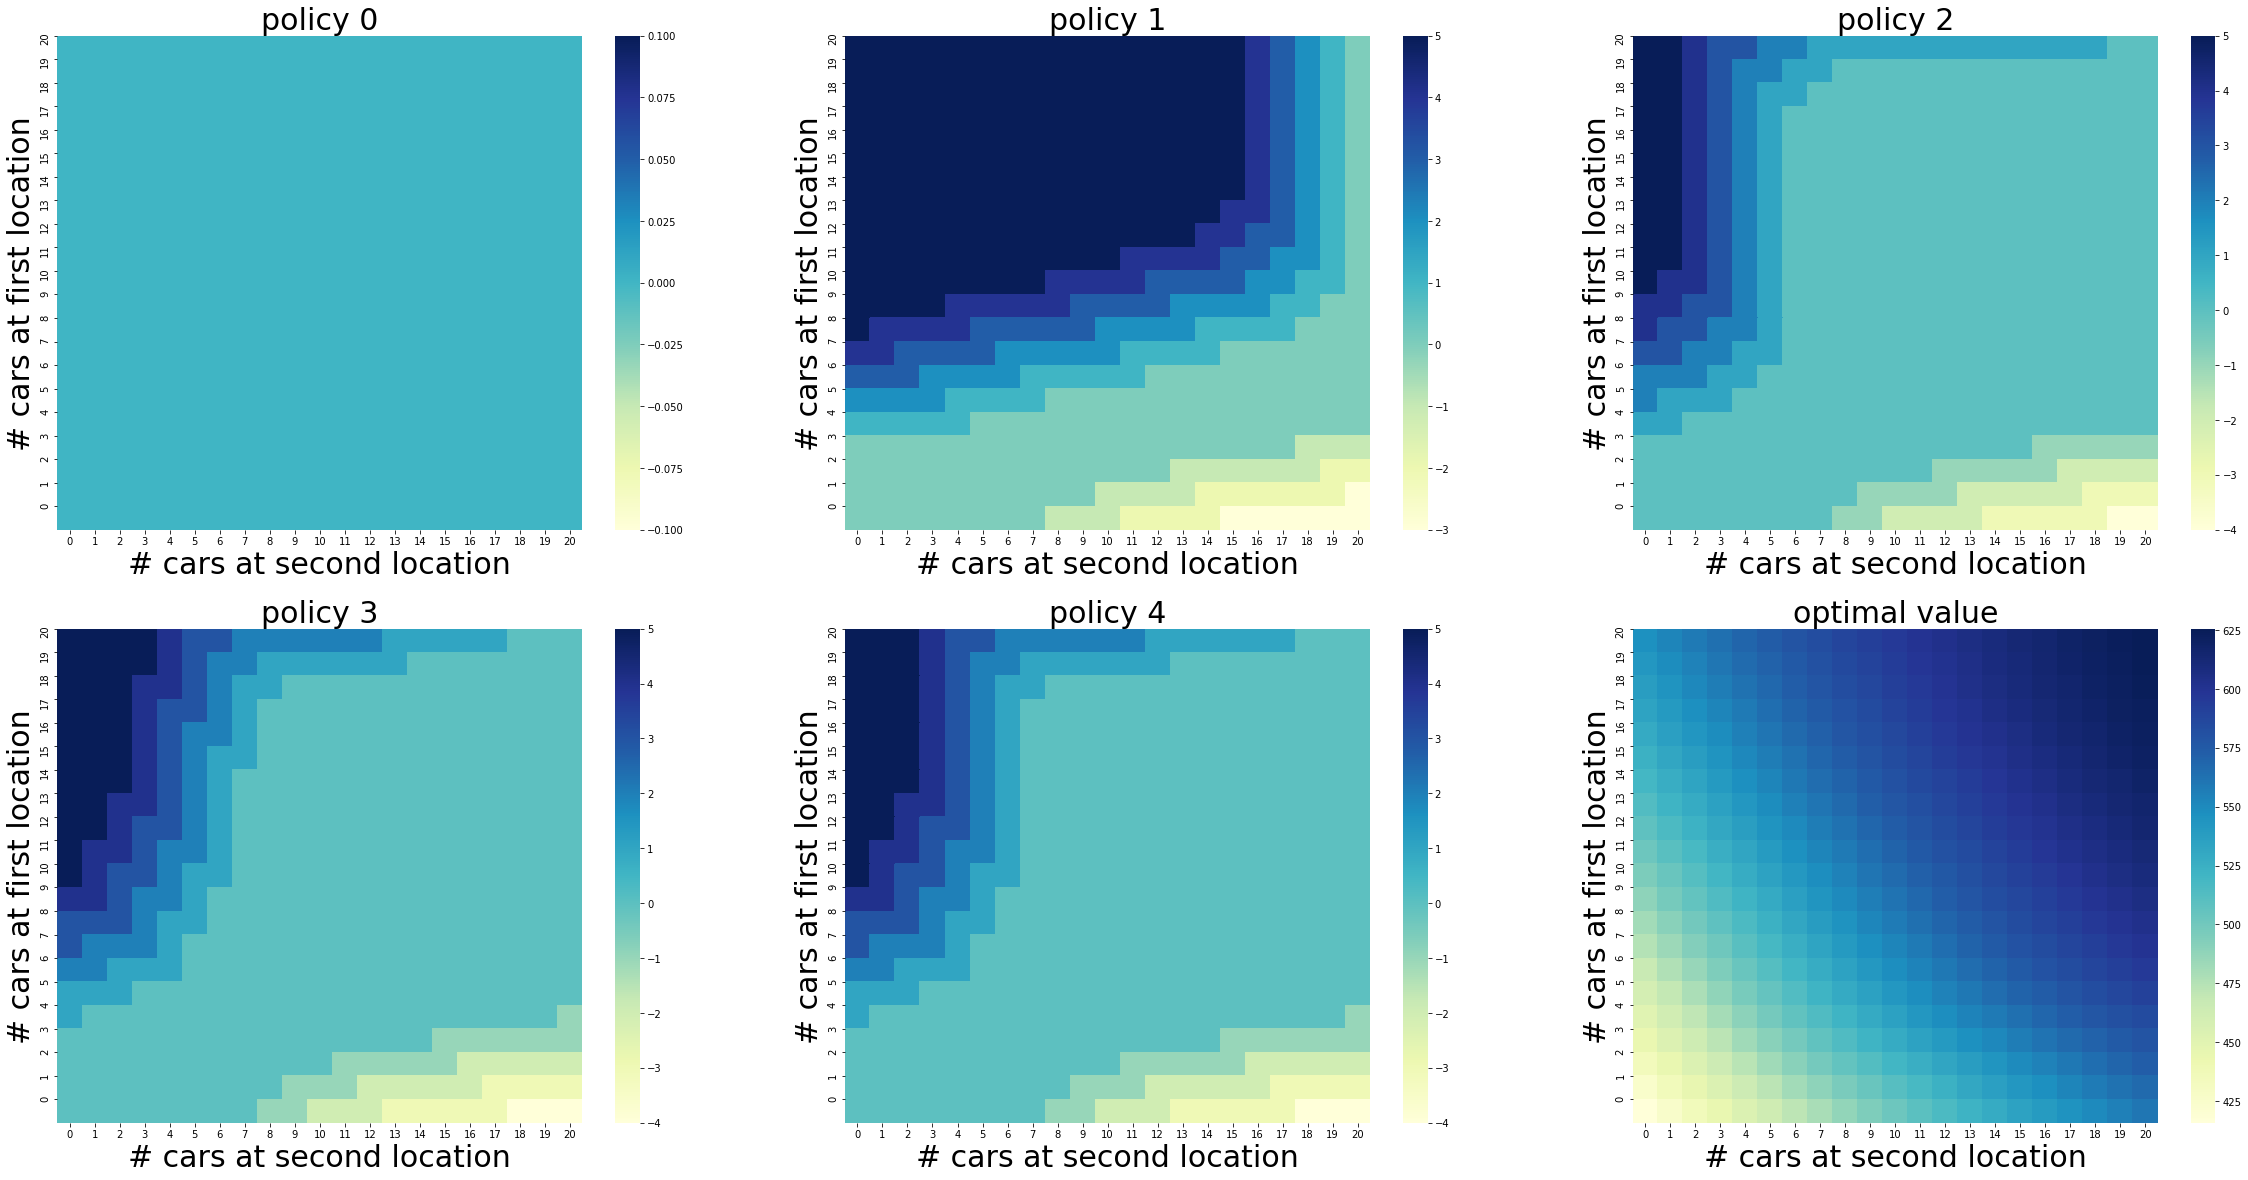

In [75]:
figure_4_2()